Hi Yannick,\
hier ein kleines, vorbereitetes Beispiel wie man meine Grenzschicht-Methode benutzen kann.\
Um deine eigenen Daten zu verarbeiten müsstest du deine Vertikalprofile auf 21 Level in den unteren 5km interpolieren. Meine Modelldaten haben ein Terrain-folgendes Koordinatensystem, deswegen speichere ich die Höhen
auch. Die Formel für die Level find ich gerade nicht auf die Schnelle.\
Die 10 Beispiele sind zufällig die ersten 10 in meinem Datensatz.\
Im Moment funktioniert die Methode nur für konvektive und neutrale Grenzschichten.\
VG Till

In [17]:
path_models = "./models/"
path_data = "./data/"

n_levels = 21 #number of considered height levels

# Minimum and maximum values in the training set:
pt_min = 276.74657877595683
pt_max = 329.4730806440175

q_min = 0.0
q_max = 0.019215934

In [13]:
import numpy as np
import pickle

from tensorflow.keras import models

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def normalize_to_interval(x, a, b, min_x=None, max_x=None):
    """
    Normalizes the data vector "x" to take values in the range [a, b].
    "min_x" and "max_x" correspond to the theoretically lowest or hightest value
    of "x", which might not actually be present in "x".
    Note that the highest (lowest) value in x will take the value of a (b) if
    "min_x" and/or "max_x" are not given.
    """
    
    if min_x is None:          
        min_x = np.min(x)
    if max_x is None:
        max_x = np.max(x)
                          
    return( (b - a) * ( x - min_x ) / ( max_x - min_x ) + a )

In [14]:
with open(path_data + "heights.pickle", "rb") as f:
        heights = pickle.load(f)
        
with open(path_data + "pottemps.pickle", "rb") as f:
        pottemps = pickle.load(f)
        
with open(path_data + "humids.pickle", "rb") as f:
        humids = pickle.load(f)
        
with open(path_data + "pblhs.pickle", "rb") as f:
        pblhs = pickle.load(f)

In [21]:
# Vectorize data:
n_samples = len(pblhs)
data = np.full([n_samples, n_levels, 2], np.nan)
targets = np.full(n_samples, -1)

for i in range(n_samples):
    data[i, :, 0] = pottemps[i][:n_levels]
    data[i, :, 1] = humids[i][:n_levels]
        
    targets[i] = np.where(pblhs[i] == heights[i])[0][0]
        
# Normalize data:
#train_data[:, 0:n_classes] = normalize_to_interval(train_data[:, 0:n_classes], 0., 1., 250., 350.)
data[:, :, 0] = normalize_to_interval(data[:, :, 0], 0., 1.)
data[:, :, 1] = normalize_to_interval(data[:, :, 1], 0., 1.)

In [7]:
with open(path_models + "covnet_combi.json", "r") as json_file:
    loaded_model_json = json_file.read()
    model = models.model_from_json(loaded_model_json)

model.load_weights(path_models + "covnet_weights_combi.h5")

2022-12-05 11:12:37.297448: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 11:12:37.298591: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [26]:
# Estimation:
est_ml = np.argmax(model.predict(data), axis=1)
est_pblh = [heights[i_sample][i_est] for i_sample, i_est in enumerate(est_ml)]

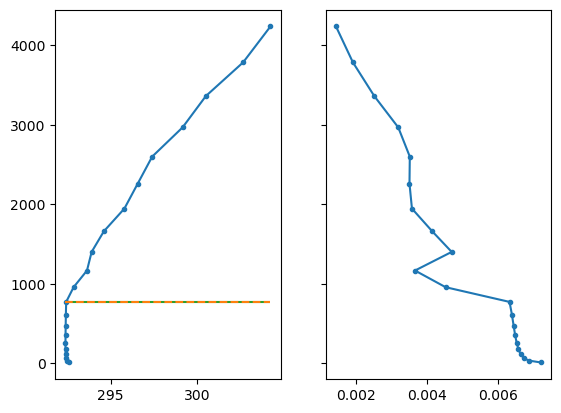

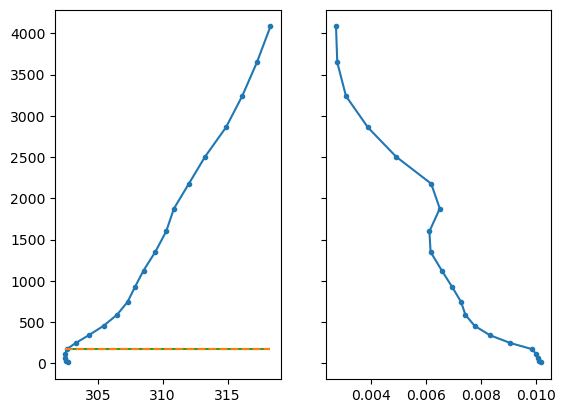

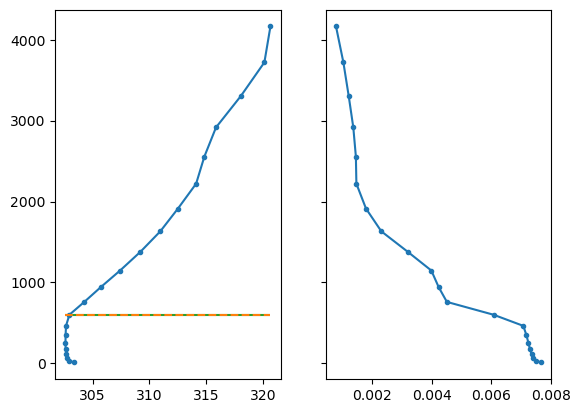

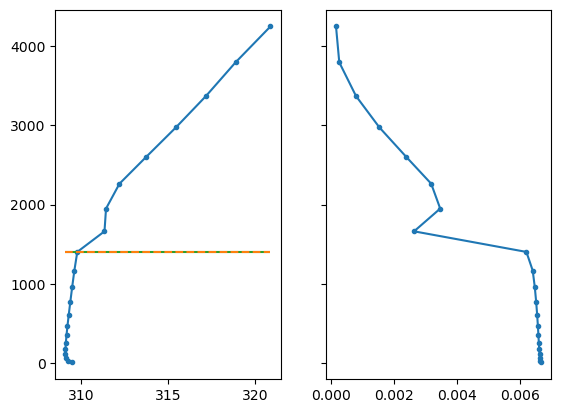

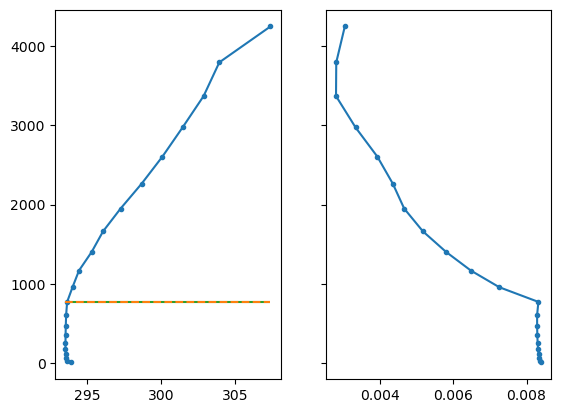

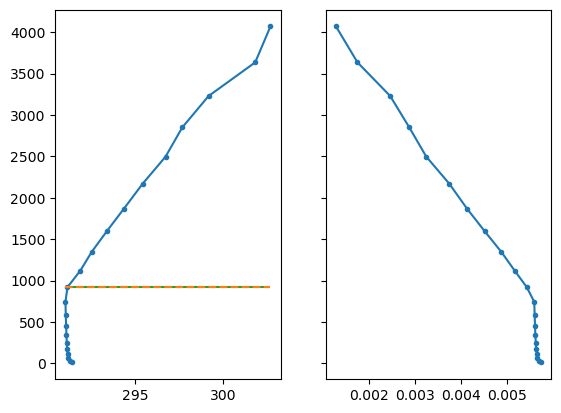

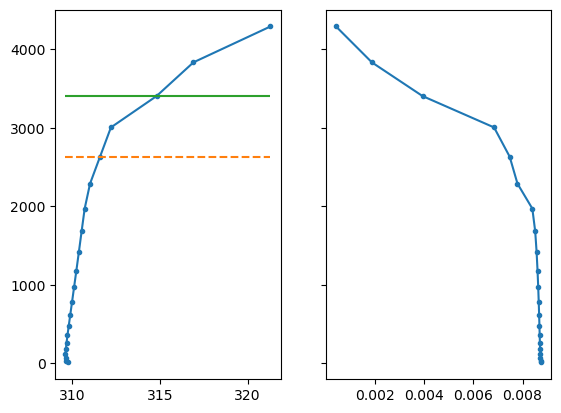

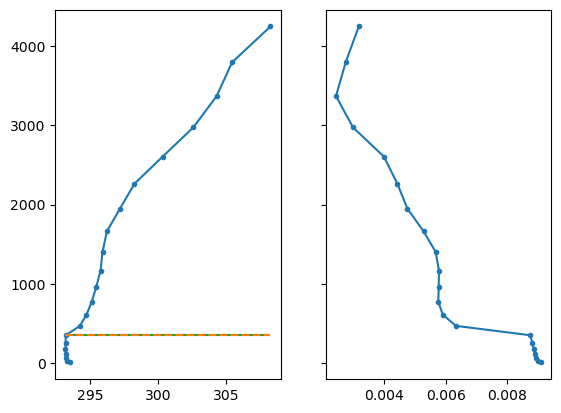

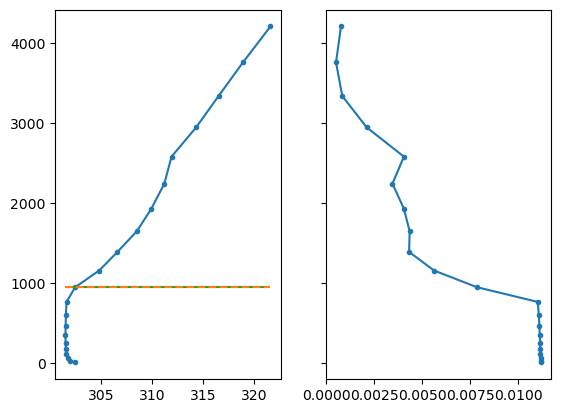

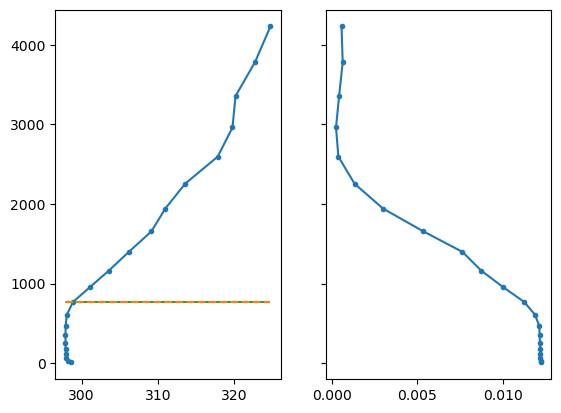

In [28]:
for i_sample in range(n_samples):
    fig, axs = plt.subplots(1, 2, sharey=True)

    example_height = heights[i_sample]
    example_pt = pottemps[i_sample]
    example_humid = humids[i_sample]

    axs[0].plot(example_pt, example_height, marker=".")
    axs[0].hlines(pblhs[i_sample], np.min(example_pt), np.max(example_pt), colors="tab:green")
    axs[0].hlines(est_pblh[i_sample], np.min(example_pt), np.max(example_pt), colors="tab:orange", linestyle="dashed")

    axs[1].plot(example_humid, example_height, marker=".")

    plt.show()